In [19]:
import os
import tensorflow as tf
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [20]:
bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)
E_id = pcaBasis_id[:,:30].reshape((-1,3,30))
E_exp = pcaBasis_exp[:,:20].reshape((-1,3,20))
sigma_id = np.sqrt(pcaVariance_id[:30])
sigma_exp = np.sqrt(pcaVariance_exp[:20])

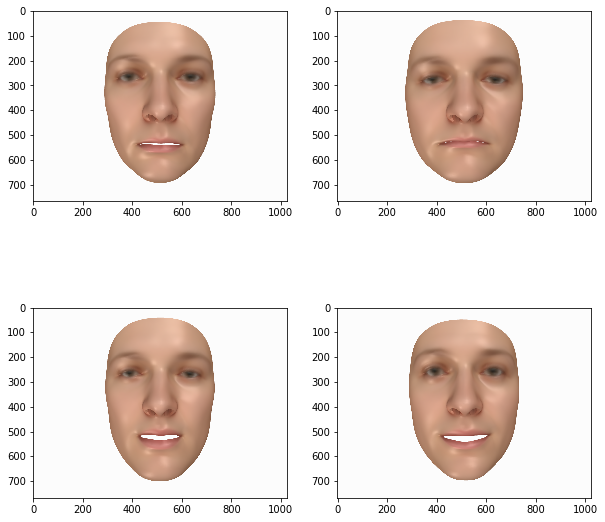

In [21]:
# Generate point clouds using uniform sample
os.makedirs('results/',exist_ok=True)
fig1 = plt.figure(figsize = (10,10))
for i in range(4):
    alpha = np.random.uniform(-1,1,30)
    beta = np.random.uniform(-1,1,20)
    G = mu_id + E_id @ (alpha*sigma_id)  + mu_exp + E_exp @ (beta*sigma_exp)
    mesh = Mesh(G, mean_tex, triangles)
    filepath = 'results/point_cloud_sample{}.png'.format(i+1)
    mesh_to_png(filepath, mesh) 
    image = mpimg.imread(filepath)
    subplot = fig1.add_subplot(2,2,i+1)
    subplot.imshow(image)
plt.show()

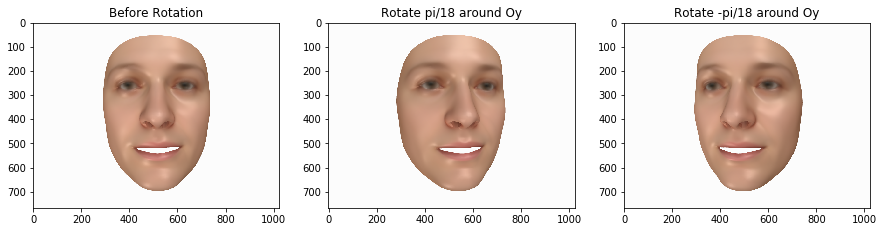

In [22]:
# Rotate around Oy
fig2 = plt.figure(figsize = (15,10))
subplot = fig2.add_subplot(1,3,1)
subplot.imshow(image)
subplot.set_title("Before Rotation")
# Rotate pi/18 around Oy 
theta = np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y1.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,2)
subplot.imshow(image_t)
subplot.set_title("Rotate pi/18 around Oy")
# Rotate -pi/18 around Oy
theta = -np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y2.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,3)
subplot.imshow(image_t)
subplot.set_title("Rotate -pi/18 around Oy")
plt.show()

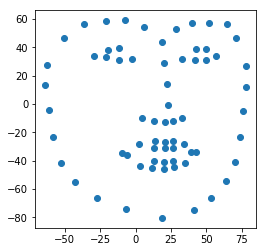

In [23]:
# visualize facial landmark points on the 2D image plane
landmark_index=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmark_index.append(int(line.split('\n')[0]))
G_landmark = np.ones((4,len(landmark_index)))
G_landmark[:3,:]= G[landmark_index,:].T
theta = np.pi/18.
T = np.array([[np.cos(theta),0, np.sin(theta),0],
              [0,1,0,0],[-np.sin(theta),0,np.cos(theta),0],
              [0,0,0,1]])
vl,vr,vb,vt = 0,1,0,1
V = np.array([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t,n,f = 0,1,0,1,1,100
P = np.array([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t-b),(t+b)/(t-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])
output = V @ P @ T @ G_landmark
plt.scatter(output[0,:],output[1,:])
plt.axes().set_aspect('equal')
plt.show()

In [24]:
test_image = mpimg.imread('test.jpg')
landmarks = detect_landmark(test_image)

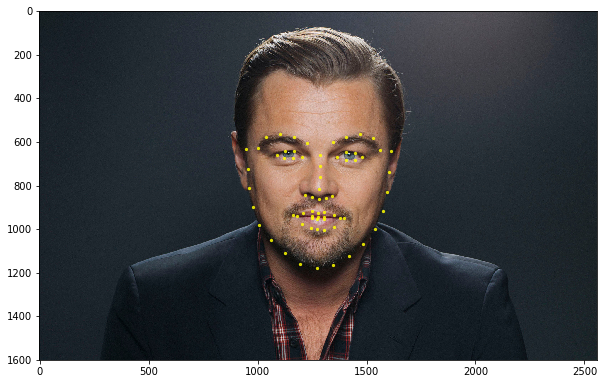

In [25]:
fig = plt.figure(figsize = (10,10))
plt.imshow(test_image)
x= landmarks[:,0]
y= landmarks[:,1]
plt.scatter(x,y,alpha=0.8,marker='o',s=5,c='yellow')

In [26]:
#load data
mu_id_tf = tf.convert_to_tensor(mu_id[landmark_index].reshape(-1,1), dtype=tf.float32)
mu_exp_tf = tf.convert_to_tensor(mu_exp[landmark_index].reshape(-1,1), dtype=tf.float32)
E_id_tf = tf.convert_to_tensor(E_id[landmark_index,:,:].reshape(-1,30), dtype=tf.float32)
E_exp_tf = tf.convert_to_tensor(E_exp[landmark_index,:,:].reshape(-1,20), dtype=tf.float32)

In [27]:
def get_transform_matrix(w,t):
    T = tf.eye(4)
    tx,ty,tz = w[0],w[1],w[2]
    R_x=tf.Variable([[1,0,0],
                     [0,tf.cos(tx),-tf.sin(tx)],
                     [0,tf.sin(tx),tf.cos(tx)]])
    R_y=tf.Variable([[tf.cos(ty),0,tf.sin(ty)],
                     [0,1,0],
                     [-tf.sin(ty),0,tf.cos(ty)]])
    R_z=tf.Variable([[tf.cos(tz),-tf.sin(tz),0],
                     [tf.sin(tz),tf.cos(tz),0],
                     [0,0,1]])
    R = R_x @ R_y @ R_z
    T = tf.concat([R,tf.reshape(t,[-1,1])],1)
    T = tf.concat([T,[[0,0,0,1]]],0)
    return T

In [28]:
Height=test_image.shape[0]
Width=test_image.shape[1]
vl,vr,vb,vt = 0,Width,0,Height
V = np.array([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t,n,f = 0,150,0,200,1,100
P = np.array([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t-b),(t+b)/(t-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])

In [33]:
theta = np.pi/18.
w = tf.Variable([theta,theta,theta],dtype=tf.float32)
t = tf.Variable([75,100,-400],dtype=tf.float32)
alpha = tf.Variable(tf.random.uniform([1,30]))
beta = tf.Variable(tf.random.uniform([1,20]))
gt_landmark = tf.placeholder(tf.float32, shape=(68,2))
# forward
G_tf = mu_id_tf+ E_id_tf @ tf.transpose(alpha*sigma_id) + mu_exp_tf + E_exp_tf@tf.transpose(beta*sigma_exp)
G_tf = tf.reshape(G_tf,[-1,3])
T = get_transform_matrix(w,t)
out = V @ P @ T @ G_landmark
pred_landmark = tf.transpose(out[:2,:])
L_landmark = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.pow((pred_landmark - gt_landmark),2),1)))
L_reg = tf.reduce_sum(tf.pow(alpha,2)) + tf.reduce_sum(tf.pow(beta,2))
L_fit = L_landmark+L_reg
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_loss = optimizer.minimize(L_fit)  
init = tf.global_variables_initializer()                              
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(10000):
        _,loss = sess.run([train_loss,L_fit],feed_dict={gt_landmark: landmarks})
        if epoch % 500 == 0:
            print("Epoch:", '%04d' % (epoch), "loss={:.9f}".format(loss))
    pred_landmark = pred_landmark.eval({gt_landmark: landmarks})

Epoch: 0000 loss=48260.839843750
Epoch: 0500 loss=11046.159179688
Epoch: 1000 loss=1072.367309570
Epoch: 1500 loss=1070.413696289
Epoch: 2000 loss=1069.981933594
Epoch: 2500 loss=1069.997924805
Epoch: 3000 loss=1069.818725586
Epoch: 3500 loss=1069.812744141
Epoch: 4000 loss=1069.951049805
Epoch: 4500 loss=1069.734741211
Epoch: 5000 loss=1069.765502930
Epoch: 5500 loss=1069.971557617
Epoch: 6000 loss=1069.721313477
Epoch: 6500 loss=1069.792724609
Epoch: 7000 loss=1069.957885742
Epoch: 7500 loss=1069.728271484
Epoch: 8000 loss=1069.816284180
Epoch: 8500 loss=1069.957153320
Epoch: 9000 loss=1069.733520508
Epoch: 9500 loss=1069.823364258


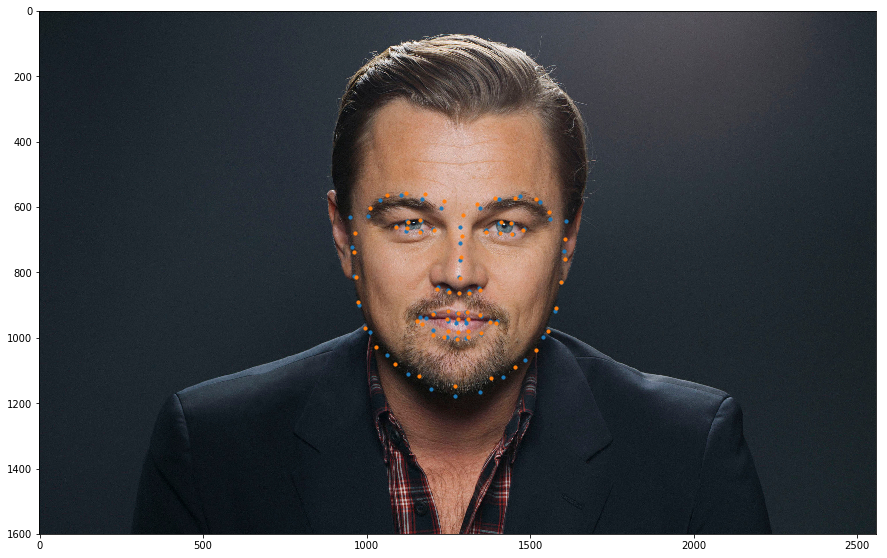

In [34]:
fig = plt.figure(figsize = (15,15))
plt.imshow(test_image)

x= landmarks[:,0]
y= landmarks[:,1]
plt.scatter(x,y,s=10)

x= pred_landmark[:,0]
y= pred_landmark[:,1]
plt.scatter(x,y,s=10)